In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
neg_img, neg_name = load_data('test', 'n', 'neg', data = 'sm', extract_name = True)
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm', extract_name = True)
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm', extract_name = True)
active_img, active_name = load_data('test', 'h', 'active', data = 'sm', extract_name = True)
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm', extract_name = True)
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm', extract_name = True)
str_img, str_name = load_data('test', 'd', 'str', data = 'sm', extract_name = True)

In [4]:
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (12449, 512, 512, 3) (12449, 2)
red spot: (1112, 512, 512, 3) (1112, 2)
angioectasia: (37, 512, 512, 3) (37, 2)
active_bleeding: (858, 512, 512, 3) (858, 2)
erosion: (1476, 512, 512, 3) (1476, 2)
ulcer: (1464, 512, 512, 3) (1464, 2)
stricture: (207, 512, 512, 3) (207, 2)


In [5]:
len(redspot_name) + len(angio_name) + len(active_name)

2007

In [6]:
len(ero_name) + len(ulcer_name) + len(str_name)

3147

In [7]:
len(redspot_name) + len(angio_name) + len(active_name) + len(ero_name) + len(ulcer_name) + len(str_name)

5154

In [8]:
np.random.choice(len(neg_name), 5154)

array([3439,  801, 5548, ..., 7789, 8358, 5348])

In [9]:
neg2_img = neg_img[np.random.choice(len(neg_name), 5154)]

In [10]:
neg2_img.shape

(5154, 512, 512, 3)

In [11]:
neg2_label = one_hot(neg2_img, 0)

# Model Inference

In [12]:
nh_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'N3H7_' in i and 'core' not in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'N3D7_' in i and 'core' not in i])
b_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'B_1' in i and 'core' not in i])

In [13]:
nh_list

['N3H7_1_2001111824_3220_val_acc_1.00_val_loss_0.007533',
 'N3H7_1_2001111839_4020_val_acc_1.00_val_loss_0.005300',
 'N3H7_1_2001111848_4500_val_acc_1.00_val_loss_0.003259',
 'N3H7_1_2001111913_5840_val_acc_1.00_val_loss_0.001676',
 'N3H7_1_2001111922_6330_val_acc_1.00_val_loss_0.001517']

In [14]:
nd_list

['N3D7_1_2001112020_10030_val_acc_1.00_val_loss_0.002929',
 'N3D7_1_2001112050_11750_val_acc_1.00_val_loss_0.002261',
 'N3D7_1_2001112106_12660_val_acc_1.00_val_loss_0.001616',
 'N3D7_1_2001112127_13860_val_acc_1.00_val_loss_0.001455',
 'N3D7_1_2001112136_14360_val_acc_1.00_val_loss_0.001324']

In [15]:
b_list

['B_1_2001112003_8680_val_acc_1.00_val_loss_0.002840',
 'B_1_2001112051_11240_val_acc_1.00_val_loss_0.002717',
 'B_1_2001112054_11400_val_acc_1.00_val_loss_0.002119',
 'B_1_2001112127_13190_val_acc_1.00_val_loss_0.001404',
 'B_1_2001112151_14470_val_acc_1.00_val_loss_0.000708']

In [44]:
nh_path = './model/' + nh_list[-1]
nd_path = './model/' + nd_list[-1]
b_path = './model/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

In [45]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

#: 12449 / Inference Time: 00:02:02
#: 1112 / Inference Time: 00:00:10
#: 37 / Inference Time: 00:00:00
#: 858 / Inference Time: 00:00:08
#: 1476 / Inference Time: 00:00:14
#: 1464 / Inference Time: 00:00:14
#: 207 / Inference Time: 00:00:01


In [46]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

#: 12449 / Inference Time: 00:01:01
#: 1112 / Inference Time: 00:00:05
#: 37 / Inference Time: 00:00:00
#: 858 / Inference Time: 00:00:04
#: 1476 / Inference Time: 00:00:07
#: 1464 / Inference Time: 00:00:07
#: 207 / Inference Time: 00:00:01


In [47]:
neg2_e_output, neg2_nh_output, neg2_nd_output = model_prob(E_model, neg2_img, model_type = 'ensemble')
neg2_b_output = model_prob(B_model, neg2_img)

#: 5154 / Inference Time: 00:00:49
#: 5154 / Inference Time: 00:00:25


# Evaluation

In [48]:
cls = classification_metric()

## Accuracy per lesion

In [49]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 98.48 %
Accuracy: 91.55 %
Accuracy: 100.00 %
Accuracy: 98.60 %


In [50]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 97.92 %
Accuracy: 95.60 %
Accuracy: 96.93 %
Accuracy: 99.03 %


In [51]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 98.40 %
Accuracy: 92.36 %
Accuracy: 100.00 %
Accuracy: 98.83 %
Accuracy: 95.39 %
Accuracy: 95.77 %
Accuracy: 98.07 %


In [52]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 96.91 %
Accuracy: 94.06 %
Accuracy: 100.00 %
Accuracy: 99.07 %
Accuracy: 96.61 %
Accuracy: 97.75 %
Accuracy: 99.03 %


## Confusion Matrix

In [53]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

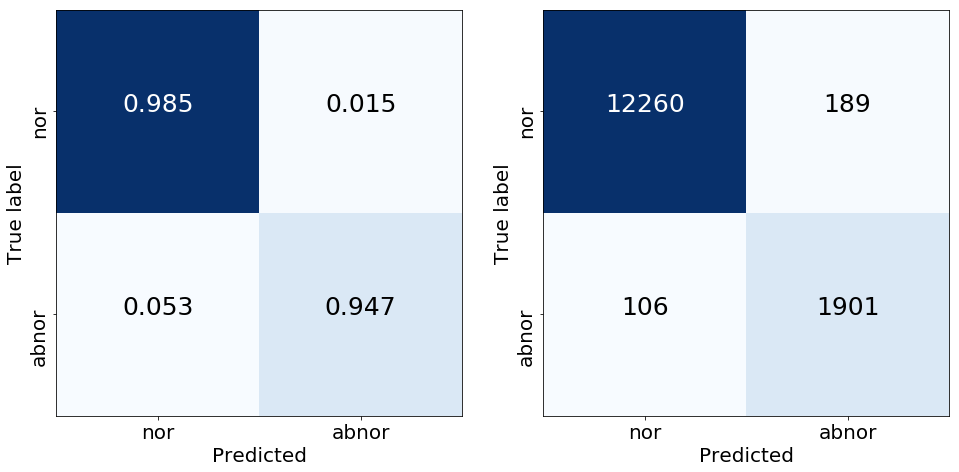

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [55]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

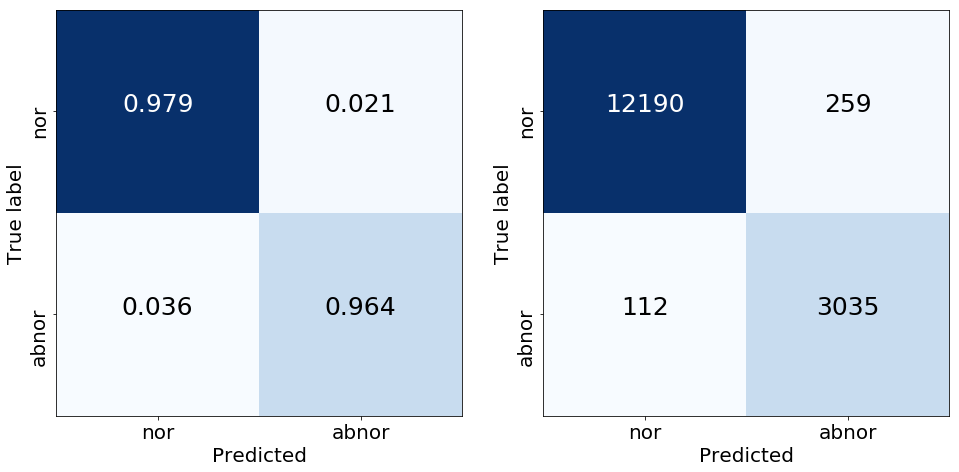

In [56]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [57]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

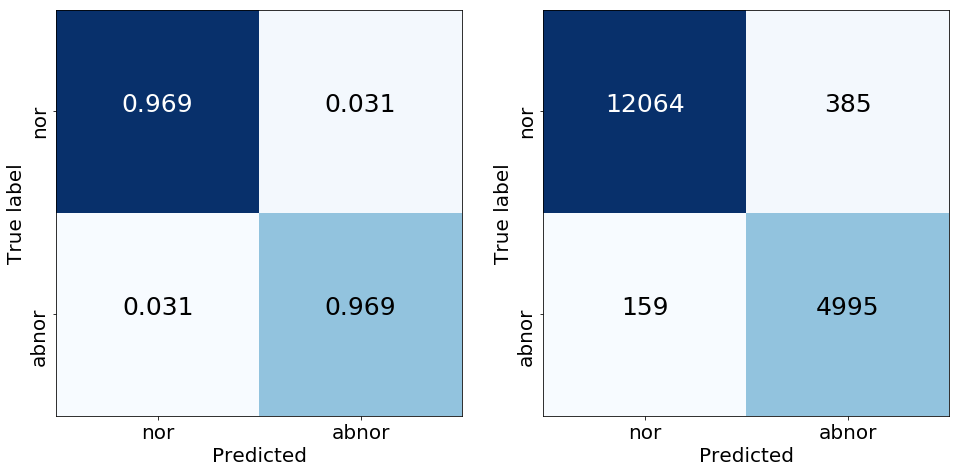

In [58]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [59]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

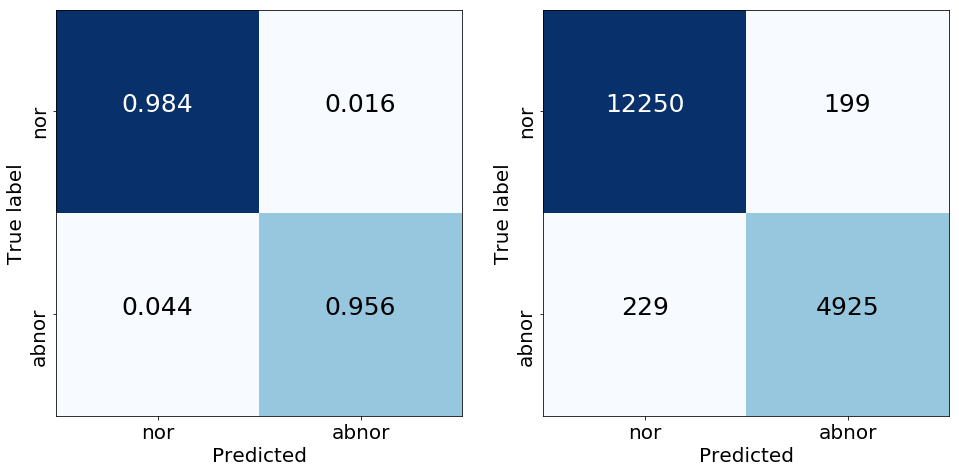

In [60]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [61]:
e_outputs = np.vstack([neg2_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

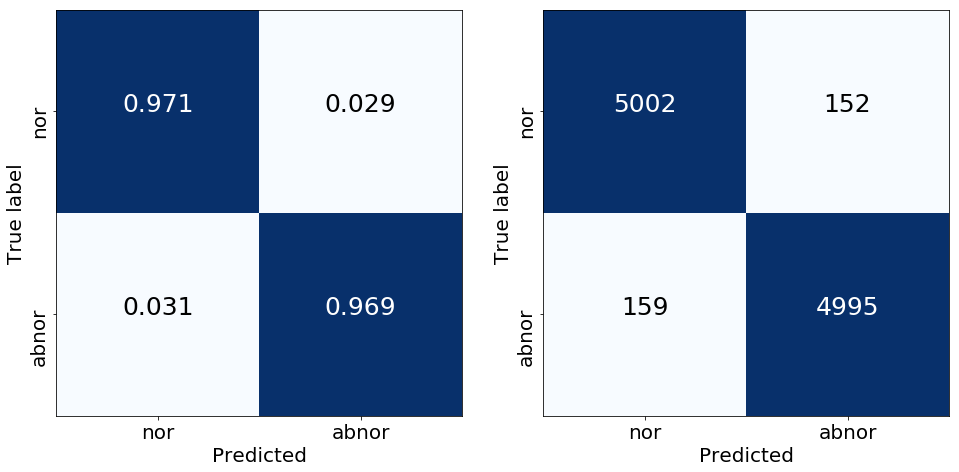

In [62]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [63]:
b_outputs = np.vstack([neg2_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

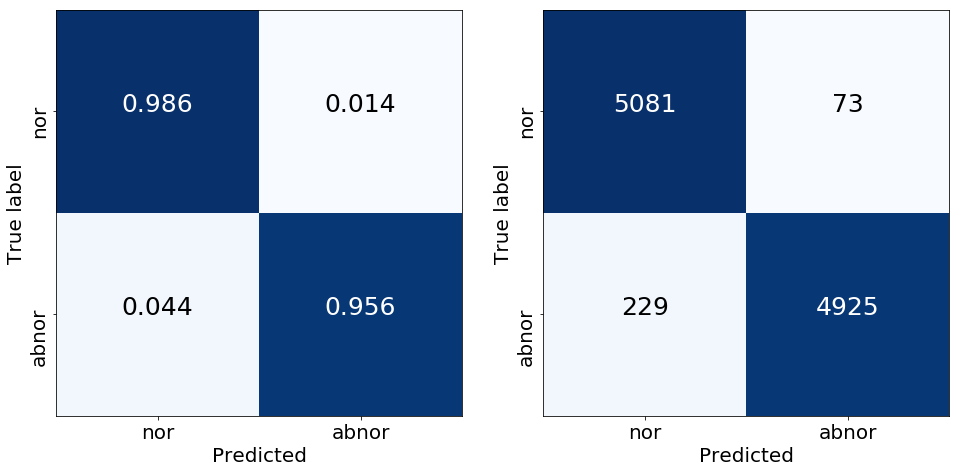

In [64]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [65]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [66]:
from sklearn.model_selection import KFold

In [67]:
def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [68]:
n_g = 10

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

In [69]:
_, neg2_idxs = k_fold_idx(n_fold = n_g, dataset = neg2_label)

In [70]:
from sklearn.metrics import roc_curve, auc

In [71]:
labels[0]

array([1, 0])

In [72]:
e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


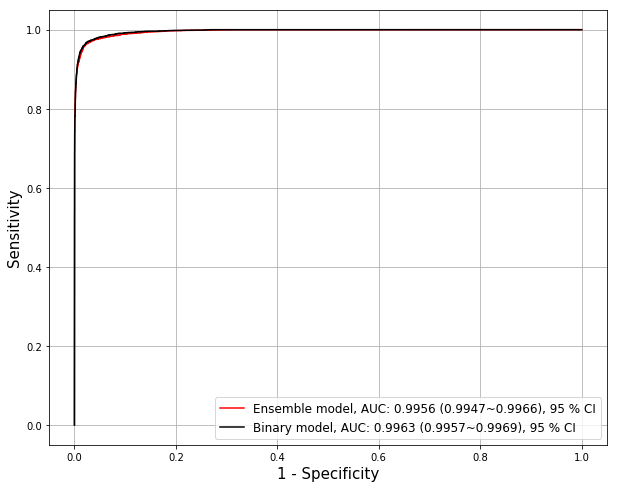

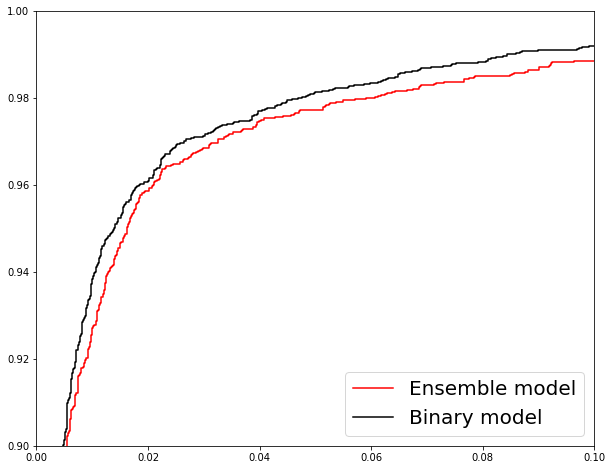

In [73]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

In [74]:
e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

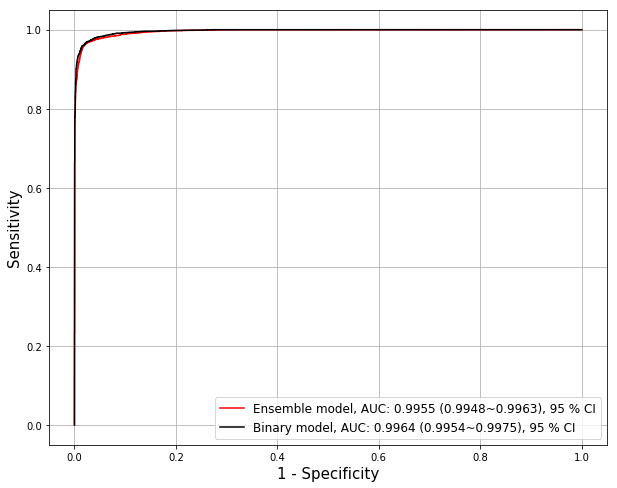

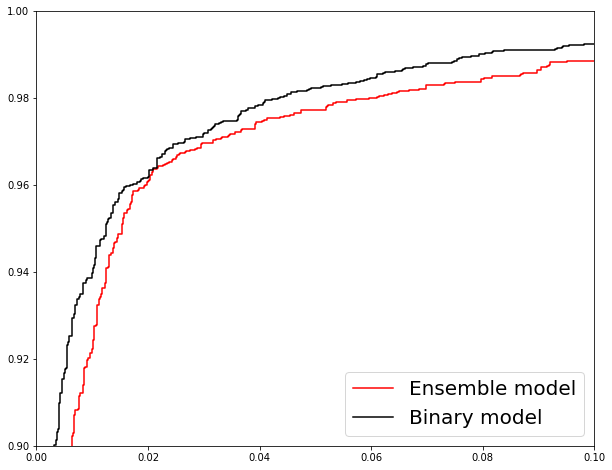

In [75]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg2_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg2_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [76]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(1763, 2)
(1763, 2)
(1762, 2)
(1762, 2)
(1761, 2)
(1761, 2)
(1760, 2)
(1758, 2)
(1757, 2)
(1756, 2)


In [77]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [78]:
b_metrices

array([[0.97787862, 0.95559846, 0.98714859, 0.98162939, 0.96868885],
       [0.97958026, 0.97297297, 0.98232932, 0.9886823 , 0.9581749 ],
       [0.97673099, 0.95938104, 0.98393574, 0.98314607, 0.96124031],
       [0.97900114, 0.95551257, 0.98875502, 0.98165869, 0.97244094],
       [0.9750142 , 0.94573643, 0.98714859, 0.97772474, 0.96825397],
       [0.96990346, 0.94573643, 0.97991968, 0.9775641 , 0.95126706],
       [0.97045455, 0.95533981, 0.97670683, 0.98143664, 0.94433781],
       [0.97440273, 0.95126706, 0.98393574, 0.98      , 0.96062992],
       [0.97438816, 0.953125  , 0.98313253, 0.98076923, 0.95874263],
       [0.97949886, 0.9609375 , 0.98713826, 0.98397436, 0.96850394]])

In [79]:
e_metrices

array([[0.96937039, 0.96525097, 0.97108434, 0.98533007, 0.93283582],
       [0.97390811, 0.98069498, 0.97108434, 0.99179655, 0.93382353],
       [0.97502838, 0.9729207 , 0.97590361, 0.98860862, 0.94371482],
       [0.96481271, 0.9516441 , 0.97028112, 0.97972425, 0.93005671],
       [0.96763203, 0.96899225, 0.96706827, 0.98688525, 0.92421442],
       [0.96422487, 0.96317829, 0.96465863, 0.98442623, 0.91866913],
       [0.96647727, 0.97087379, 0.96465863, 0.98766447, 0.91911765],
       [0.97155859, 0.98050682, 0.96787149, 0.99176955, 0.92633517],
       [0.96186682, 0.9609375 , 0.962249  , 0.98357964, 0.91280148],
       [0.976082  , 0.9765625 , 0.97588424, 0.99021207, 0.94339623]])

In [80]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 97.57 (97.32 ~ 97.82)
Sen --- 95.56 (94.99 ~ 96.12)
Spec --- 98.40 (98.13 ~ 98.67)
NPV --- 98.17 (97.94 ~ 98.40)
PPV --- 96.12 (95.50 ~ 96.75)

Ensemble model
Accr --- 96.91 (96.56 ~ 97.26)
Sen --- 96.92 (96.26 ~ 97.57)
Spec --- 96.91 (96.58 ~ 97.24)
NPV --- 98.70 (98.42 ~ 98.98)
PPV --- 92.85 (92.11 ~ 93.59)


In [81]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(1034, 2)
(1034, 2)
(1033, 2)
(1033, 2)
(1031, 2)
(1031, 2)
(1030, 2)
(1028, 2)
(1027, 2)
(1027, 2)


In [82]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [83]:
b_metrices

array([[0.97098646, 0.95559846, 0.98643411, 0.95676692, 0.98605578],
       [0.97485493, 0.97297297, 0.97674419, 0.97297297, 0.97674419],
       [0.97483059, 0.95938104, 0.99031008, 0.96052632, 0.99001996],
       [0.97483059, 0.95551257, 0.99418605, 0.95708955, 0.99396378],
       [0.95635306, 0.94573643, 0.96699029, 0.94676806, 0.96633663],
       [0.96508244, 0.94573643, 0.98446602, 0.94766355, 0.98387097],
       [0.97475728, 0.95533981, 0.99417476, 0.95700935, 0.99393939],
       [0.96789883, 0.95126706, 0.98446602, 0.95300752, 0.98387097],
       [0.969815  , 0.953125  , 0.98640777, 0.95488722, 0.98585859],
       [0.97760467, 0.9609375 , 0.99417476, 0.96240602, 0.99393939]])

In [84]:
e_metrices

array([[0.96808511, 0.96525097, 0.97093023, 0.96531792, 0.97087379],
       [0.97388781, 0.98069498, 0.96705426, 0.98035363, 0.96761905],
       [0.96708616, 0.9729207 , 0.96124031, 0.97254902, 0.96175908],
       [0.96418199, 0.9516441 , 0.97674419, 0.95274102, 0.97619048],
       [0.96799224, 0.96899225, 0.96699029, 0.9688716 , 0.96711799],
       [0.96508244, 0.96317829, 0.96699029, 0.96324952, 0.96692607],
       [0.97184466, 0.97087379, 0.97281553, 0.97093023, 0.97276265],
       [0.97178988, 0.98050682, 0.9631068 , 0.98023715, 0.96360153],
       [0.969815  , 0.9609375 , 0.97864078, 0.96183206, 0.97813121],
       [0.97857838, 0.9765625 , 0.98058252, 0.97678917, 0.98039216]])

In [85]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 97.07 (96.62 ~ 97.52)
Sen --- 95.56 (94.99 ~ 96.12)
Spec --- 98.58 (97.97 ~ 99.20)
NPV --- 95.69 (95.15 ~ 96.23)
PPV --- 98.55 (97.92 ~ 99.17)

Ensemble model
Accr --- 96.98 (96.67 ~ 97.29)
Sen --- 96.92 (96.26 ~ 97.57)
Spec --- 97.05 (96.58 ~ 97.52)
NPV --- 96.93 (96.30 ~ 97.56)
PPV --- 97.05 (96.61 ~ 97.50)


### Equal-Variance Test

In [86]:
from scipy.stats import bartlett

In [87]:
accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 1.200, pvalue=0.273408067646
bartlett test for sensitivity: 0.187, pvalue=0.665206699736
bartlett test for specificity: 0.624, pvalue=0.429591247004
bartlett test for negative predictive values: 0.203, pvalue=0.651967574361
bartlett test for positive predictive values: 0.938, pvalue=0.332693239516


In [88]:
from scipy.stats import levene

In [89]:
accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.620, pvalue=0.441467349948
levene test for sensitivity: 0.567, pvalue=0.461019528128
levene test for specificity: 0.072, pvalue=0.791004628270
levene test for negative predictive values: 0.612, pvalue=0.444326951598
levene test for positive predictive values: 0.213, pvalue=0.649979280514


### Normality Test

In [90]:
from scipy.stats import ks_2samp

In [91]:
accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.400, pvalue=0.417523652818
Kolmogorov-Smirnov test for sensitivity: 0.700, pvalue=0.012340600576
Kolmogorov-Smirnov test for specificity: 0.800, pvalue=0.002056766763
Kolmogorov-Smirnov test for negative predictive values: 0.700, pvalue=0.012340600576
Kolmogorov-Smirnov test for positive predictive values: 0.800, pvalue=0.002056766763


### Wilcoxon signed-ranks test (not normal and paired group)

In [92]:
from scipy.stats import wilcoxon

In [93]:
accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 15.000, pvalue=0.674424072235
wilcoxon signed-ranks test for sensitivity: 1.000, pvalue=0.006910429808
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.007632441648
wilcoxon signed-ranks test for negative predictive values: 1.000, pvalue=0.006910429808
wilcoxon signed-ranks test for positive predictive values: 1.000, pvalue=0.006910429808


/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Paired two-sample t-Test (normal and paired group)

In [94]:
from scipy.stats import ttest_rel

In [95]:
accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: 0.449, pvalue=0.663889838747
t-statistics for sensitivity: -4.712, pvalue=0.001101308296
t-statistics for specificity: 5.948, pvalue=0.000216001996
t-statistics for negative predictive values: -4.500, pvalue=0.001488973773
t-statistics for positive predictive values: 5.819, pvalue=0.000253228870


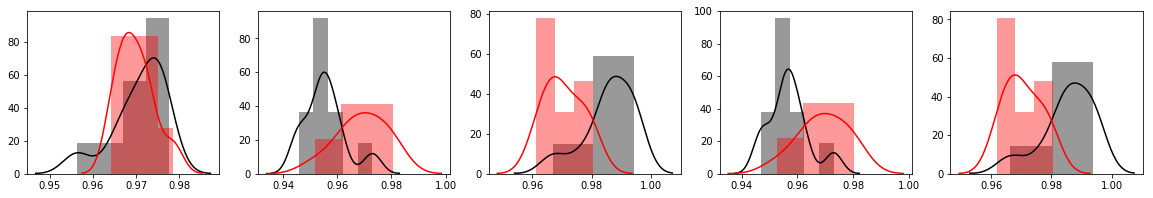

In [96]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()